In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import display, HTML
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
# Read the CSV files
application_df = pd.read_csv('dataset/application_record.csv')
credit_df = pd.read_csv('dataset/credit_record.csv')

# Print total rows in each dataframe
print(f"Shape of original application dataframe: {application_df.shape}")
print(f"Shape of original credit dataframe: {credit_df.shape}")

print("Processing data to only preserve the rows that share the have an ID on both files")

# Get the unique IDs from both dataframes
application_ids = set(application_df['ID'])
credit_ids = set(credit_df['ID'])

# Find the intersection of IDs
common_ids = application_ids.intersection(credit_ids)

# Filter both dataframes to keep only the rows with common IDs
application_filtered = application_df[application_df['ID'].isin(common_ids)]
credit_filtered = credit_df[credit_df['ID'].isin(common_ids)]

# Reset the index of the filtered dataframes
application_filtered = application_filtered.reset_index(drop=True)
credit_filtered = credit_filtered.reset_index(drop=True)

# Print the number of rows in each filtered dataframe
print(f"Shape of filtered application dataframe: {application_filtered.shape}")
print(f"Shape of filtered credit dataframe: {credit_filtered.shape}")

application_filtered.to_csv('dataset/application_filtered.csv')
credit_filtered.to_csv('dataset/credit_filtered.csv')

Shape of original application dataframe: (438557, 18)
Shape of original credit dataframe: (1048575, 3)
Processing data to only preserve the rows that share the have an ID on both files
Shape of filtered application dataframe: (36457, 18)
Shape of filtered credit dataframe: (777715, 3)


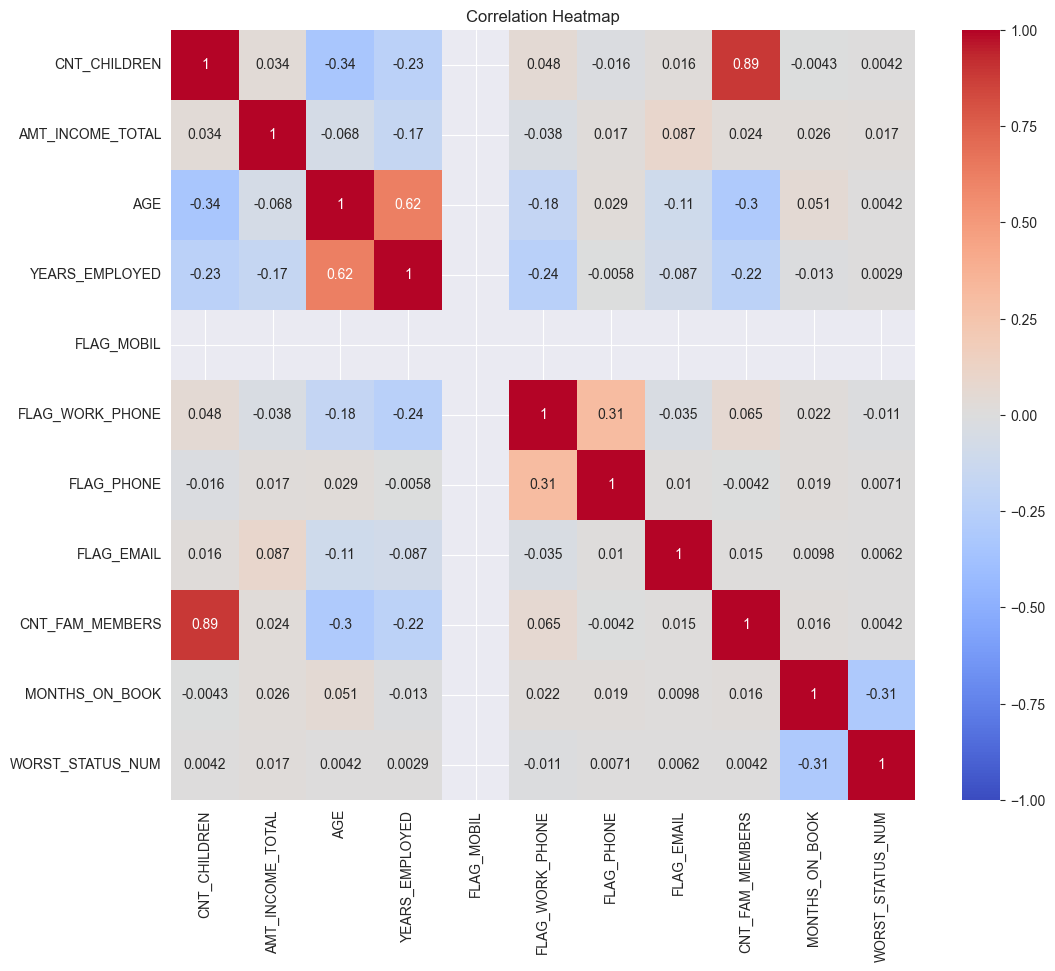

,count,mean,std,min,25%,50%,75%,max
ID,36457.00,5078227.00,41875.24,5008804.00,5042028.00,5074614.00,5115396.00,5150487.00
CODE_GENDER,36457.00,0.67,0.47,0.00,0.00,1.00,1.00,1.00
FLAG_OWN_CAR,36457.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
FLAG_OWN_REALTY,36457.00,0.67,0.47,0.00,0.00,1.00,1.00,1.00
CNT_CHILDREN,36457.00,0.43,0.74,0.00,0.00,0.00,1.00,19.00
AMT_INCOME_TOTAL,36457.00,186685.74,101789.23,27000.00,121500.00,157500.00,225000.00,1575000.00
DAYS_BIRTH,36457.00,-15975.17,4200.55,-25152.00,-19438.00,-15563.00,-12462.00,-7489.00
DAYS_EMPLOYED,36457.00,59262.94,137651.33,-15713.00,-3153.00,-1552.00,-408.00,365243.00
FLAG_MOBIL,36457.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
FLAG_WORK_PHONE,36457.00,0.23,0.42,0.00,0.00,0.00,0.00,1.00


,count,mean,std,min,25%,50%,75%,max
CODE_GENDER,36457,0.670105,0.470181,0.000000,0.000000,1.000000,1.000000,1.000000


,count,mean,std,min,25%,50%,75%,max
FLAG_OWN_CAR,36457,0.379708,0.485321,0.000000,0.000000,0.000000,1.000000,1.000000


,count,mean,std,min,25%,50%,75%,max
FLAG_OWN_REALTY,36457,0.672189,0.469422,0.000000,0.000000,1.000000,1.000000,1.000000


,count,unique,top,freq
NAME_INCOME_TYPE,36457,5,Working,18819


,count,unique,top,freq
NAME_EDUCATION_TYPE,36457,5,Secondary / secondary special,24777


,count,unique,top,freq
NAME_FAMILY_STATUS,36457,5,Married,25048


,count,unique,top,freq
NAME_HOUSING_TYPE,36457,6,House / apartment,32548


,count,unique,top,freq
OCCUPATION_TYPE,25134,18,Laborers,6211


,count,unique,top,freq
WORST_STATUS,36457,8,X,19648


In [3]:
# Create a summary of credit history
def get_worst_status(x):
    if 'C' in x:
        return 'C'
    else:
        return max(x) if len(x) > 0 else 'X'
    
credit_summary = credit_filtered.groupby('ID').agg({
                                                'MONTHS_BALANCE': 'count',
                                                'STATUS': lambda x: get_worst_status(x)
                                                }).reset_index()

credit_summary.columns = ['ID', 'MONTHS_ON_BOOK', 'WORST_STATUS']

# Merge application data with credit summary
combined_df = pd.merge(application_filtered, credit_summary, on='ID')

# Convert categorical variables to numeric
combined_df['CODE_GENDER'] = combined_df['CODE_GENDER'].map({'M': 0, 'F': 1})
combined_df['FLAG_OWN_CAR'] = combined_df['FLAG_OWN_CAR'].map({'N': 0, 'Y': 1})
combined_df['FLAG_OWN_REALTY'] = combined_df['FLAG_OWN_REALTY'].map({'N': 0, 'Y': 1})

# Convert DAYS_BIRTH and DAYS_EMPLOYED to years
combined_df['AGE'] = -combined_df['DAYS_BIRTH'] / 365
combined_df['YEARS_EMPLOYED'] = np.abs(combined_df['DAYS_EMPLOYED']) / 365

# Convert WORST_STATUS to numeric
status_order = ['C', 'X', '0', '1', '2', '3', '4', '5']
combined_df['WORST_STATUS_NUM'] = combined_df['WORST_STATUS'].apply(lambda x: status_order.index(x))

# Select numeric columns for correlation analysis
numeric_columns = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AGE', 'YEARS_EMPLOYED',
'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
'CNT_FAM_MEMBERS', 'MONTHS_ON_BOOK', 'WORST_STATUS_NUM']

# Calculate correlation matrix
corr_matrix = combined_df[numeric_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

styled_df = combined_df.describe().T.style.format("{:.2f}")
display(styled_df)

# Print value counts for categorical variables
categorical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
'OCCUPATION_TYPE', 'WORST_STATUS']

def style_categorical_summary(df, column):
    summary = df[column].describe().to_frame().T
    styled_summary = summary.style.format({
        'count': '{:.0f}',
        'unique': '{:.0f}',
        'top': '{}',
        'freq': '{:.0f}',
    })
    return styled_summary

# Process and display summary for each categorical column
for col in categorical_columns:
    styled_df = style_categorical_summary(combined_df, col)
    display(styled_df)


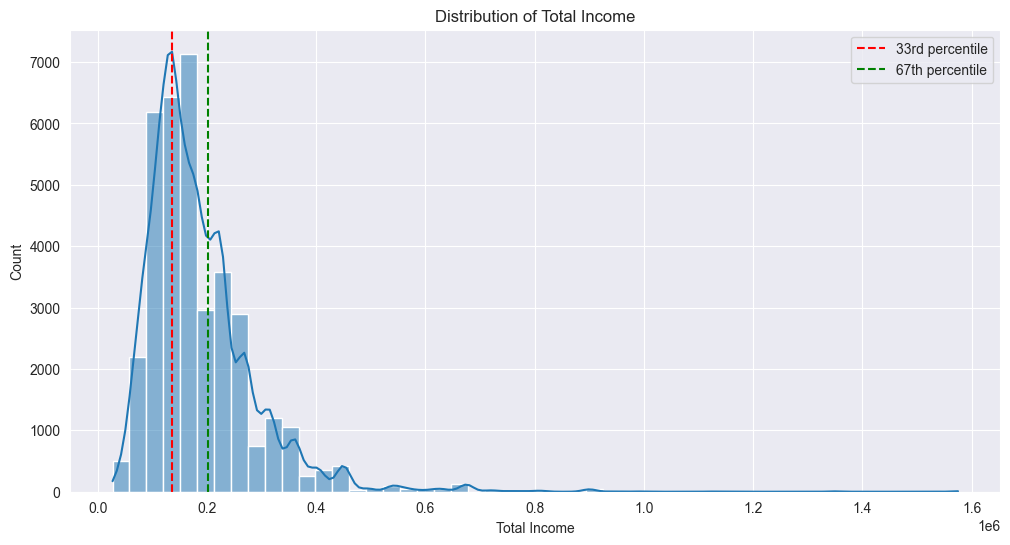

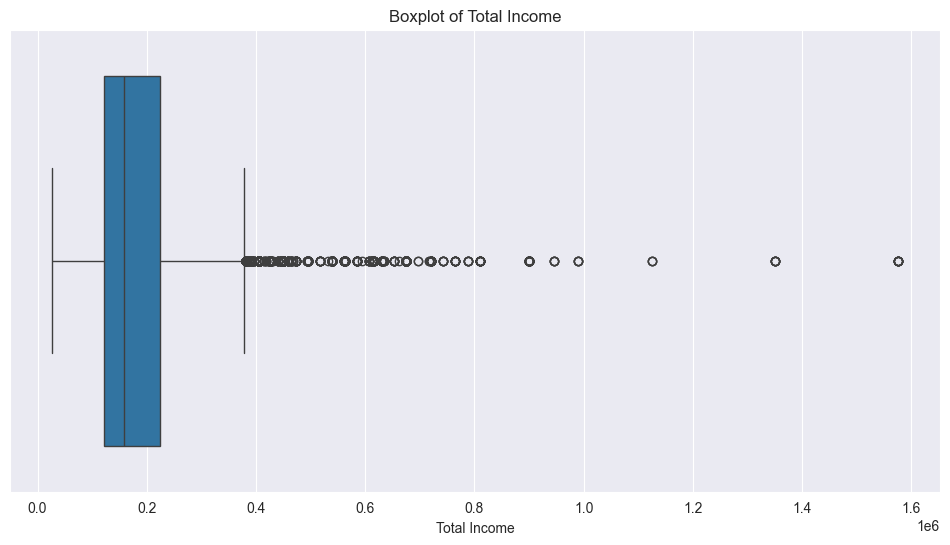

,AMT_INCOME_TOTAL
count,36457.00
mean,186685.74
std,101789.23
min,27000.00
25%,121500.00
50%,157500.00
75%,225000.00
max,1575000.00


,Number of potential outliers,Percentage of potential outliers,Non-outlier range (lower bound),Non-outlier range (upper bound)
0,1529,4.19%,-33750.00,380250.00


<Figure size 1200x600 with 0 Axes>

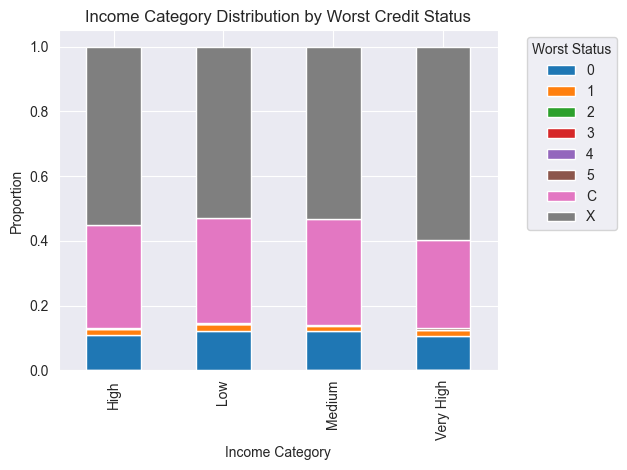

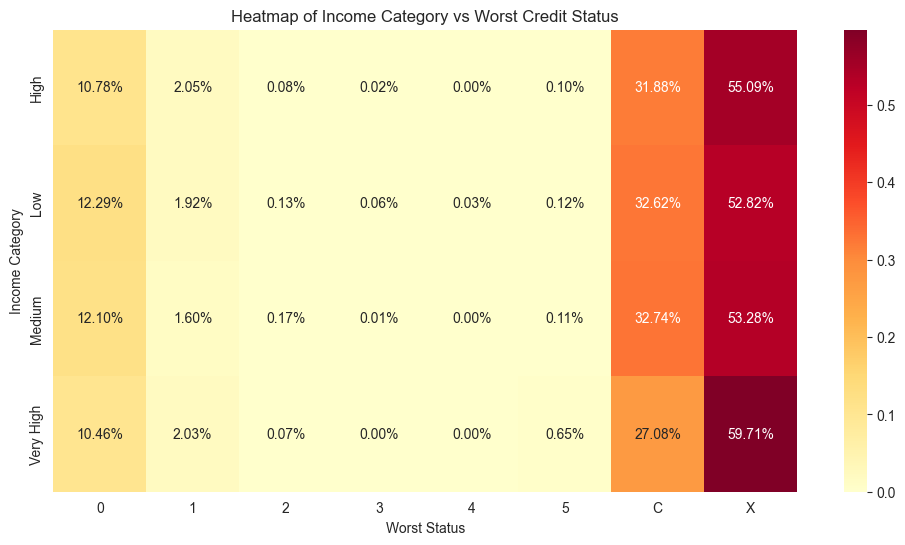

WORST_STATUS,0,1,2,3,4,5,C,X
INCOME_CATEGORY,,,,,,,,
High,10.78%,2.05%,0.08%,0.02%,0.00%,0.10%,31.88%,55.09%
Low,12.29%,1.92%,0.13%,0.06%,0.03%,0.12%,32.62%,52.82%
Medium,12.10%,1.60%,0.17%,0.01%,0.00%,0.11%,32.74%,53.28%
Very High,10.46%,2.03%,0.07%,0.00%,0.00%,0.65%,27.08%,59.71%


,proportion
INCOME_CATEGORY,
Medium,46.25%
High,25.14%
Low,24.41%
Very High,4.19%


In [4]:
# Histogram of AMT_INCOME_TOTAL
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='AMT_INCOME_TOTAL', bins=50, kde=True)
plt.title('Distribution of Total Income')
plt.xlabel('Total Income')
plt.ylabel('Count')

# Add vertical lines for the category boundaries
plt.axvline(combined_df['AMT_INCOME_TOTAL'].quantile(0.33), color='r', linestyle='--', label='33rd percentile')
plt.axvline(combined_df['AMT_INCOME_TOTAL'].quantile(0.67), color='g', linestyle='--', label='67th percentile')

plt.legend()
plt.show()

# Check for outliers using boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=combined_df['AMT_INCOME_TOTAL'])
plt.title('Boxplot of Total Income')
plt.xlabel('Total Income')
plt.show()

# Print summary statistics
summary_stats = combined_df['AMT_INCOME_TOTAL'].describe().to_frame()
styled_summary = summary_stats.style.format("{:.2f}")
display(styled_summary)

# Identify potential outliers using IQR method
Q1 = combined_df['AMT_INCOME_TOTAL'].quantile(0.25)
Q3 = combined_df['AMT_INCOME_TOTAL'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = combined_df[(combined_df['AMT_INCOME_TOTAL'] < lower_bound) | (combined_df['AMT_INCOME_TOTAL'] > upper_bound)]
outlier_info = pd.DataFrame({
    'Number of potential outliers': [len(outliers)],
    'Percentage of potential outliers': [len(outliers) / len(combined_df) * 100],
    'Non-outlier range (lower bound)': [lower_bound],
    'Non-outlier range (upper bound)': [upper_bound]
})
styled_outlier_info = outlier_info.style.format({
    'Number of potential outliers': '{:.0f}',
    'Percentage of potential outliers': '{:.2f}%',
    'Non-outlier range (lower bound)': '{:.2f}',
    'Non-outlier range (upper bound)': '{:.2f}'
})
display(styled_outlier_info)

# Grouped Income Categories

# Create income categories

def categorize_income(income):
    if income < Q1:
        return 'Low'
    elif income < Q3:
        return 'Medium'
    elif income < Q3 + 1.5 * IQR:
        return 'High'
    else:
        return 'Very High'

combined_df['INCOME_CATEGORY'] = combined_df['AMT_INCOME_TOTAL'].apply(categorize_income)

# Create a contingency table
contingency_table = pd.crosstab(combined_df['INCOME_CATEGORY'], combined_df['WORST_STATUS'], normalize='index')

# Plot stacked bar chart
plt.figure(figsize=(12, 6))
contingency_table.plot(kind='bar', stacked=True)
plt.title('Income Category Distribution by Worst Credit Status')
plt.xlabel('Income Category')
plt.ylabel('Proportion')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Heatmap of Income Category vs Worst Status
plt.figure(figsize=(12, 6))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='.2%')
plt.title('Heatmap of Income Category vs Worst Credit Status')
plt.ylabel('Income Category')
plt.xlabel('Worst Status')
plt.show()

# Print contingency table and overall distribution
styled_contingency = contingency_table.style.format("{:.2%}")
display(styled_contingency)

overall_distribution = combined_df['INCOME_CATEGORY'].value_counts(normalize=True).to_frame()
styled_distribution = overall_distribution.style.format("{:.2%}")
display(styled_distribution)

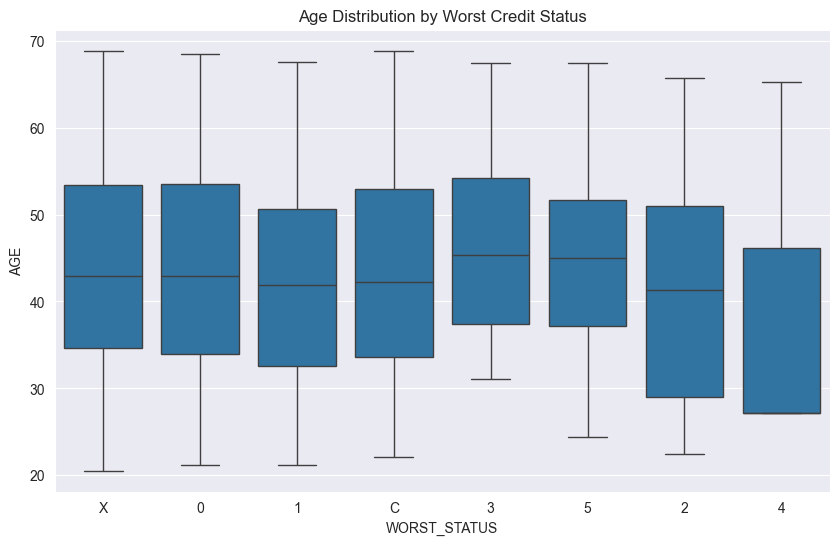

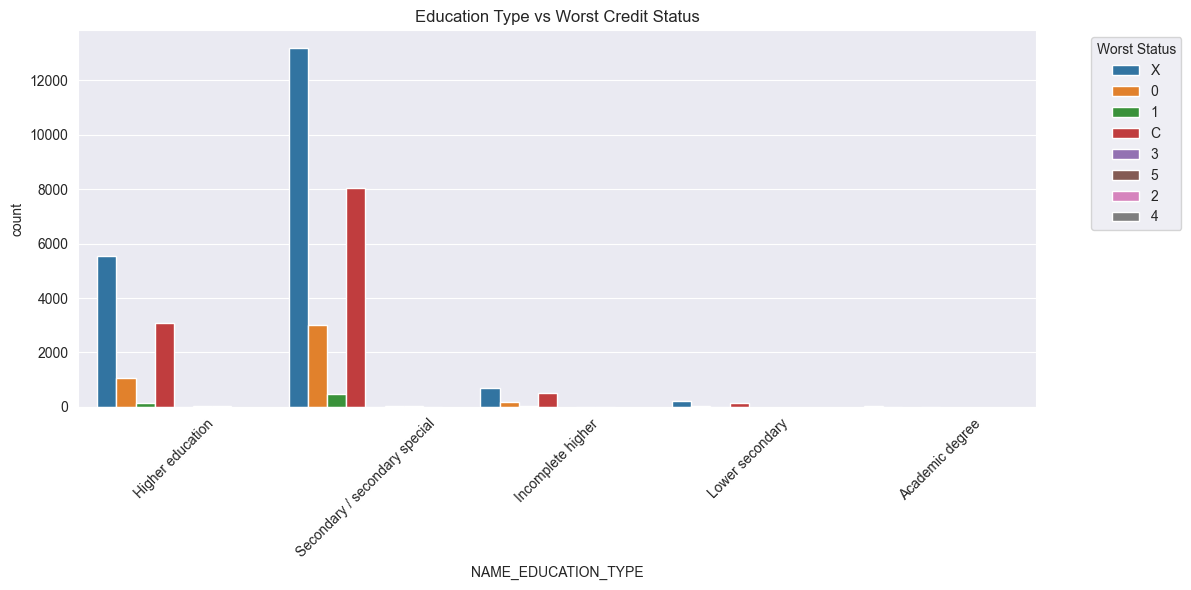

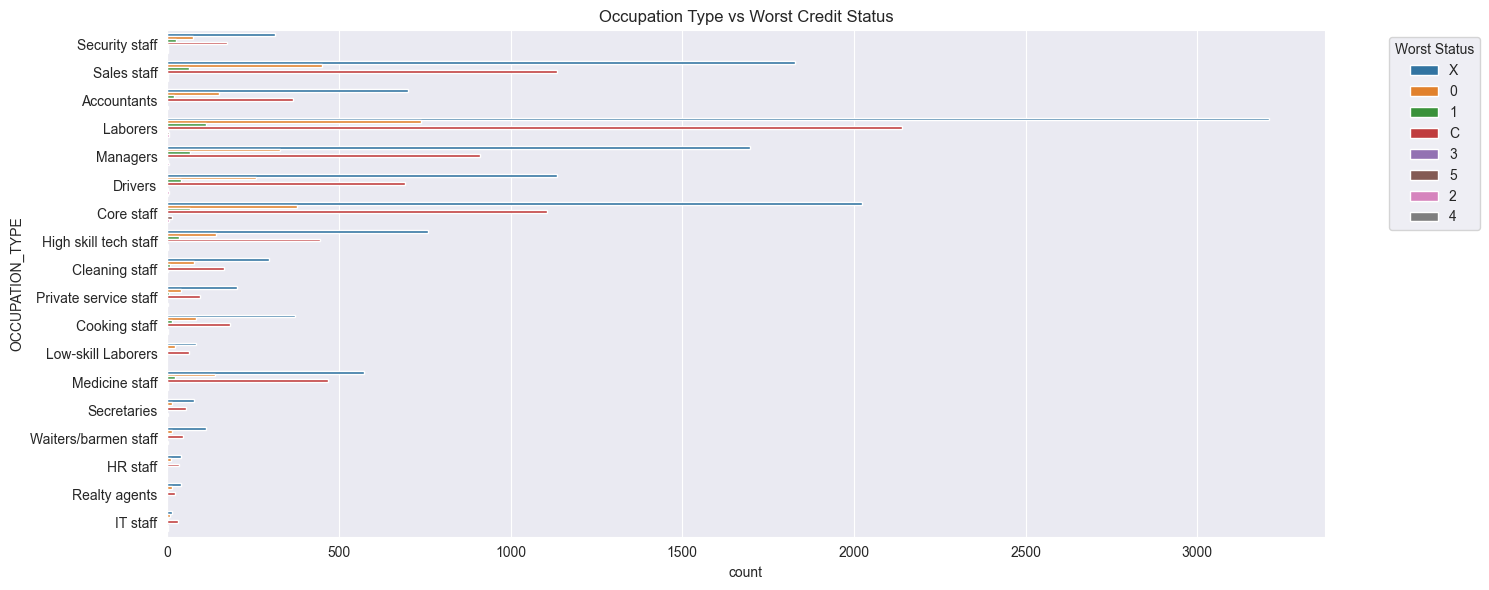

In [5]:
# Analyze the relationship between age and worst credit status
plt.figure(figsize=(10, 6))
sns.boxplot(x='WORST_STATUS', y='AGE', data=combined_df)
plt.title('Age Distribution by Worst Credit Status')
plt.show()

# Analyze the relationship between education and worst credit status
plt.figure(figsize=(12, 6))
sns.countplot(x='NAME_EDUCATION_TYPE', hue='WORST_STATUS', data=combined_df)
plt.title('Education Type vs Worst Credit Status')
plt.xticks(rotation=45)
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analyze the relationship between occupation and worst credit status
plt.figure(figsize=(15, 6))
sns.countplot(y='OCCUPATION_TYPE', hue='WORST_STATUS', data=combined_df)
plt.title('Occupation Type vs Worst Credit Status')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [6]:
# Calculate the overall bad payer rate
combined_df['HAS_PAYMENT_DELAY'] = combined_df['WORST_STATUS_NUM'] >= 2
bad_payer_rate = combined_df['HAS_PAYMENT_DELAY'].mean()
overall_bad_payer = pd.DataFrame({'Overall Payment Delay Rate': [bad_payer_rate]})
styled_overall = overall_bad_payer.style.format({'Overall Payment Delay Rate': '{:.2%}'})
display(HTML("<h3>Overall Payment Delay Rate</h3>"))
display(styled_overall)

# Analyze payment delay rate by gender
gender_bad_payer = combined_df.groupby('CODE_GENDER')['HAS_PAYMENT_DELAY'].mean().reset_index()
styled_gender = gender_bad_payer.style.format({'HAS_PAYMENT_DELAY': '{:.2%}'})
display(HTML("<h3>Payment Delay Rate by Gender</h3>"))
display(styled_gender)

# Analyze payment delay rate by income type
income_bad_payer = combined_df.groupby('NAME_INCOME_TYPE')['HAS_PAYMENT_DELAY'].mean().sort_values(ascending=False).reset_index()
styled_income = income_bad_payer.style.format({'HAS_PAYMENT_DELAY': '{:.2%}'})
display(HTML("<h3>Payment Delay Rate by Income Type</h3>"))
display(styled_income)

# Create age groups and analyze payment delay rate by age group
combined_df['AGE_GROUP'] = pd.cut(combined_df['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
age_bad_payer = combined_df.groupby('AGE_GROUP', observed=True)['HAS_PAYMENT_DELAY'].mean().sort_values(ascending=False).reset_index()
styled_age = age_bad_payer.style.format({'HAS_PAYMENT_DELAY': '{:.2%}'})
display(HTML("<h3>Payment Delay Rate by Age Group</h3>"))
display(styled_age)

,Overall Payment Delay Rate
0,13.85%


,CODE_GENDER,HAS_PAYMENT_DELAY
0,0,13.89%
1,1,13.84%


,NAME_INCOME_TYPE,HAS_PAYMENT_DELAY
0,Working,14.01%
1,Pensioner,13.91%
2,Commercial associate,13.63%
3,State servant,13.40%
4,Student,0.00%


,AGE_GROUP,HAS_PAYMENT_DELAY
0,18-25,22.90%
1,46-55,14.15%
2,36-45,13.75%
3,56-65,13.61%
4,65+,13.55%
5,26-35,13.18%


,Employment Status,Count
0,Employed,"30,322"
1,Unemployed,"6,135"


,Statistic,Value
0,count,36457.00
1,mean,174.42
2,std,371.70
3,min,0.05
4,25%,3.20
5,50%,6.90
6,75%,15.56
7,max,1000.67


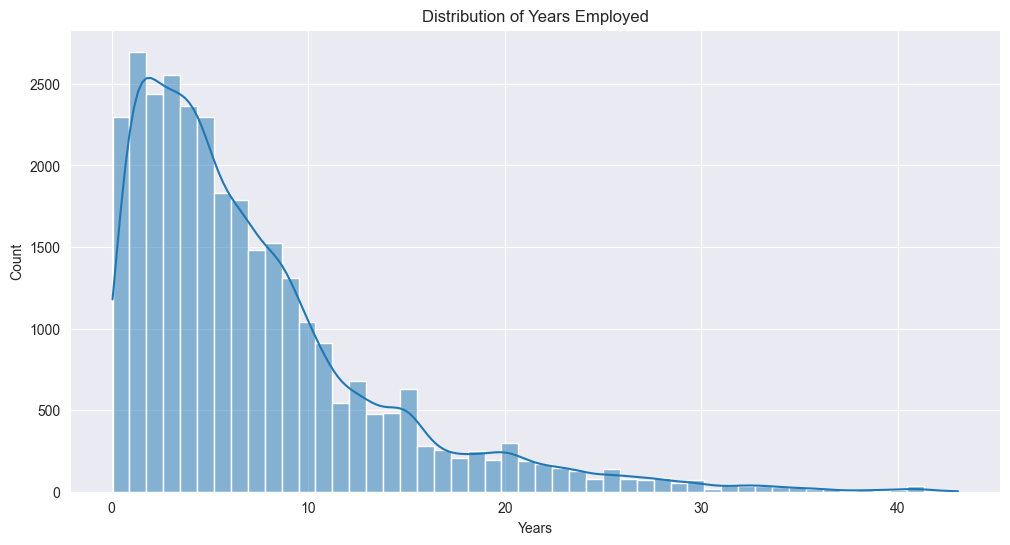

,Statistic,Value
0,count,30322.00
1,mean,33.31
2,std,9.57
3,min,17.94
4,25%,25.48
5,50%,31.98
6,75%,40.16
7,max,65.40


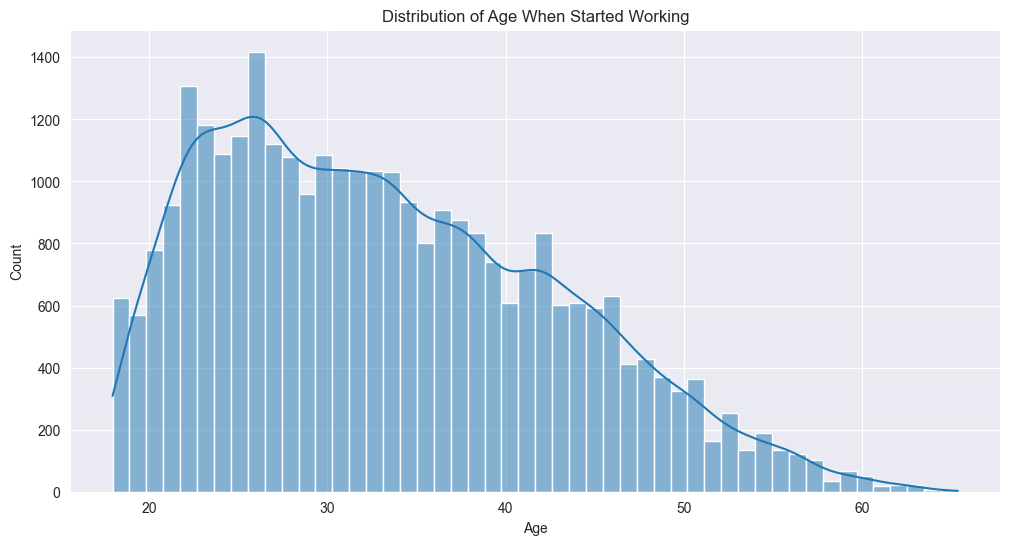

In [7]:
# Create a new column for employment status
combined_df['EMPLOYMENT_STATUS'] = np.where(combined_df['DAYS_EMPLOYED'] < 0, 'Employed', 'Unemployed')

# Display employment status counts
employment_status_counts = combined_df['EMPLOYMENT_STATUS'].value_counts().reset_index()
employment_status_counts.columns = ['Employment Status', 'Count']
styled_status_counts = employment_status_counts.style.format({'Count': '{:,}'})
display(HTML("<h3>Employment Status Counts</h3>"))
display(styled_status_counts)

# Display years employed statistics
years_employed_stats = combined_df['YEARS_EMPLOYED'].describe().reset_index()
years_employed_stats.columns = ['Statistic', 'Value']
styled_years_stats = years_employed_stats.style.format({'Value': '{:.2f}'})
display(HTML("<h3>Years Employed Statistics (for Employed individuals)</h3>"))
display(styled_years_stats)

# Visualize the distribution of years employed
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df[combined_df['EMPLOYMENT_STATUS'] == 'Employed'], 
             x='YEARS_EMPLOYED', kde=True, bins=50)
plt.title('Distribution of Years Employed')
plt.xlabel('Years')
plt.show()

# Additional analysis: Age when started working
combined_df['AGE_EMPLOYED'] = np.where(combined_df['EMPLOYMENT_STATUS'] == 'Employed', 
                                       combined_df['AGE'] - combined_df['YEARS_EMPLOYED'], np.nan)

# Display age when started working statistics
age_employed_stats = combined_df[combined_df['EMPLOYMENT_STATUS'] == 'Employed']['AGE_EMPLOYED'].describe().reset_index()
age_employed_stats.columns = ['Statistic', 'Value']
styled_age_stats = age_employed_stats.style.format({'Value': '{:.2f}'})
display(HTML("<h3>Age when started working (for employed individuals)</h3>"))
display(styled_age_stats)

plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df[combined_df['EMPLOYMENT_STATUS'] == 'Employed'], 
             x='AGE_EMPLOYED', kde=True, bins=50)
plt.title('Distribution of Age When Started Working')
plt.xlabel('Age')
plt.show()

In [8]:
# Create a cross-tabulation of gender and worst status
gender_status_crosstab = pd.crosstab(combined_df['CODE_GENDER'], combined_df['WORST_STATUS'], normalize='index')

# Style the cross-tabulation
styled_crosstab = gender_status_crosstab.style.format("{:.2%}").background_gradient(cmap='YlOrRd')

# Display the cross-tabulation
display(HTML("<h3>Cross-tabulation of Gender and Worst Status</h3>"))
display(styled_crosstab)


WORST_STATUS,0,1,2,3,4,5,C,X
CODE_GENDER,,,,,,,,
0,11.51%,2.02%,0.16%,0.03%,0.02%,0.15%,32.54%,53.57%
1,11.86%,1.71%,0.12%,0.02%,0.00%,0.12%,32.11%,54.05%


<Figure size 1200x600 with 0 Axes>

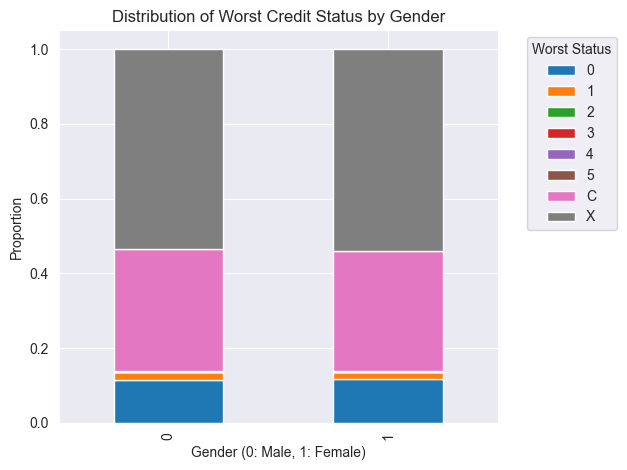

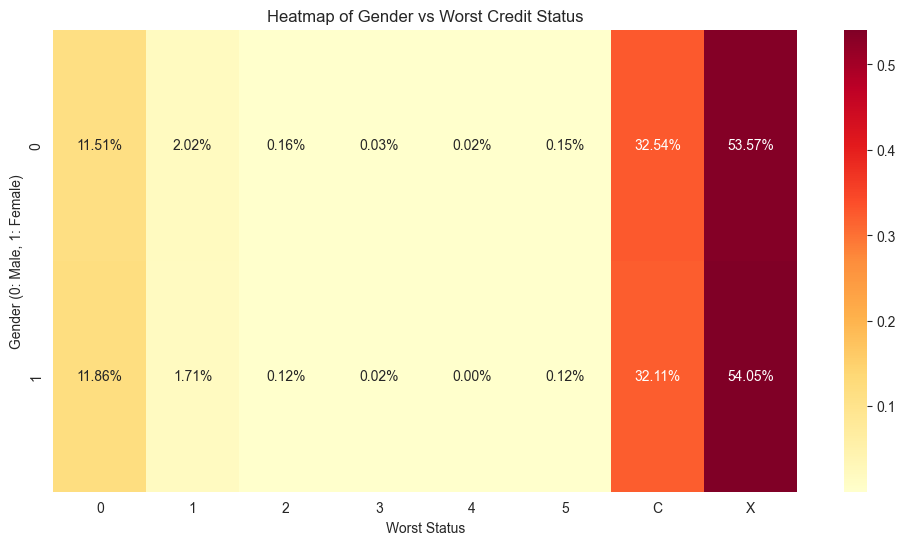

In [9]:
# Stacked bar chart of gender vs worst status
plt.figure(figsize=(12, 6))
gender_status_crosstab.plot(kind='bar', stacked=True)
plt.title('Distribution of Worst Credit Status by Gender')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Proportion')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Heatmap of gender vs worst status
plt.figure(figsize=(12, 6))
sns.heatmap(gender_status_crosstab, annot=True, cmap='YlOrRd', fmt='.2%')
plt.title('Heatmap of Gender vs Worst Credit Status')
plt.ylabel('Gender (0: Male, 1: Female)')
plt.xlabel('Worst Status')
plt.show()


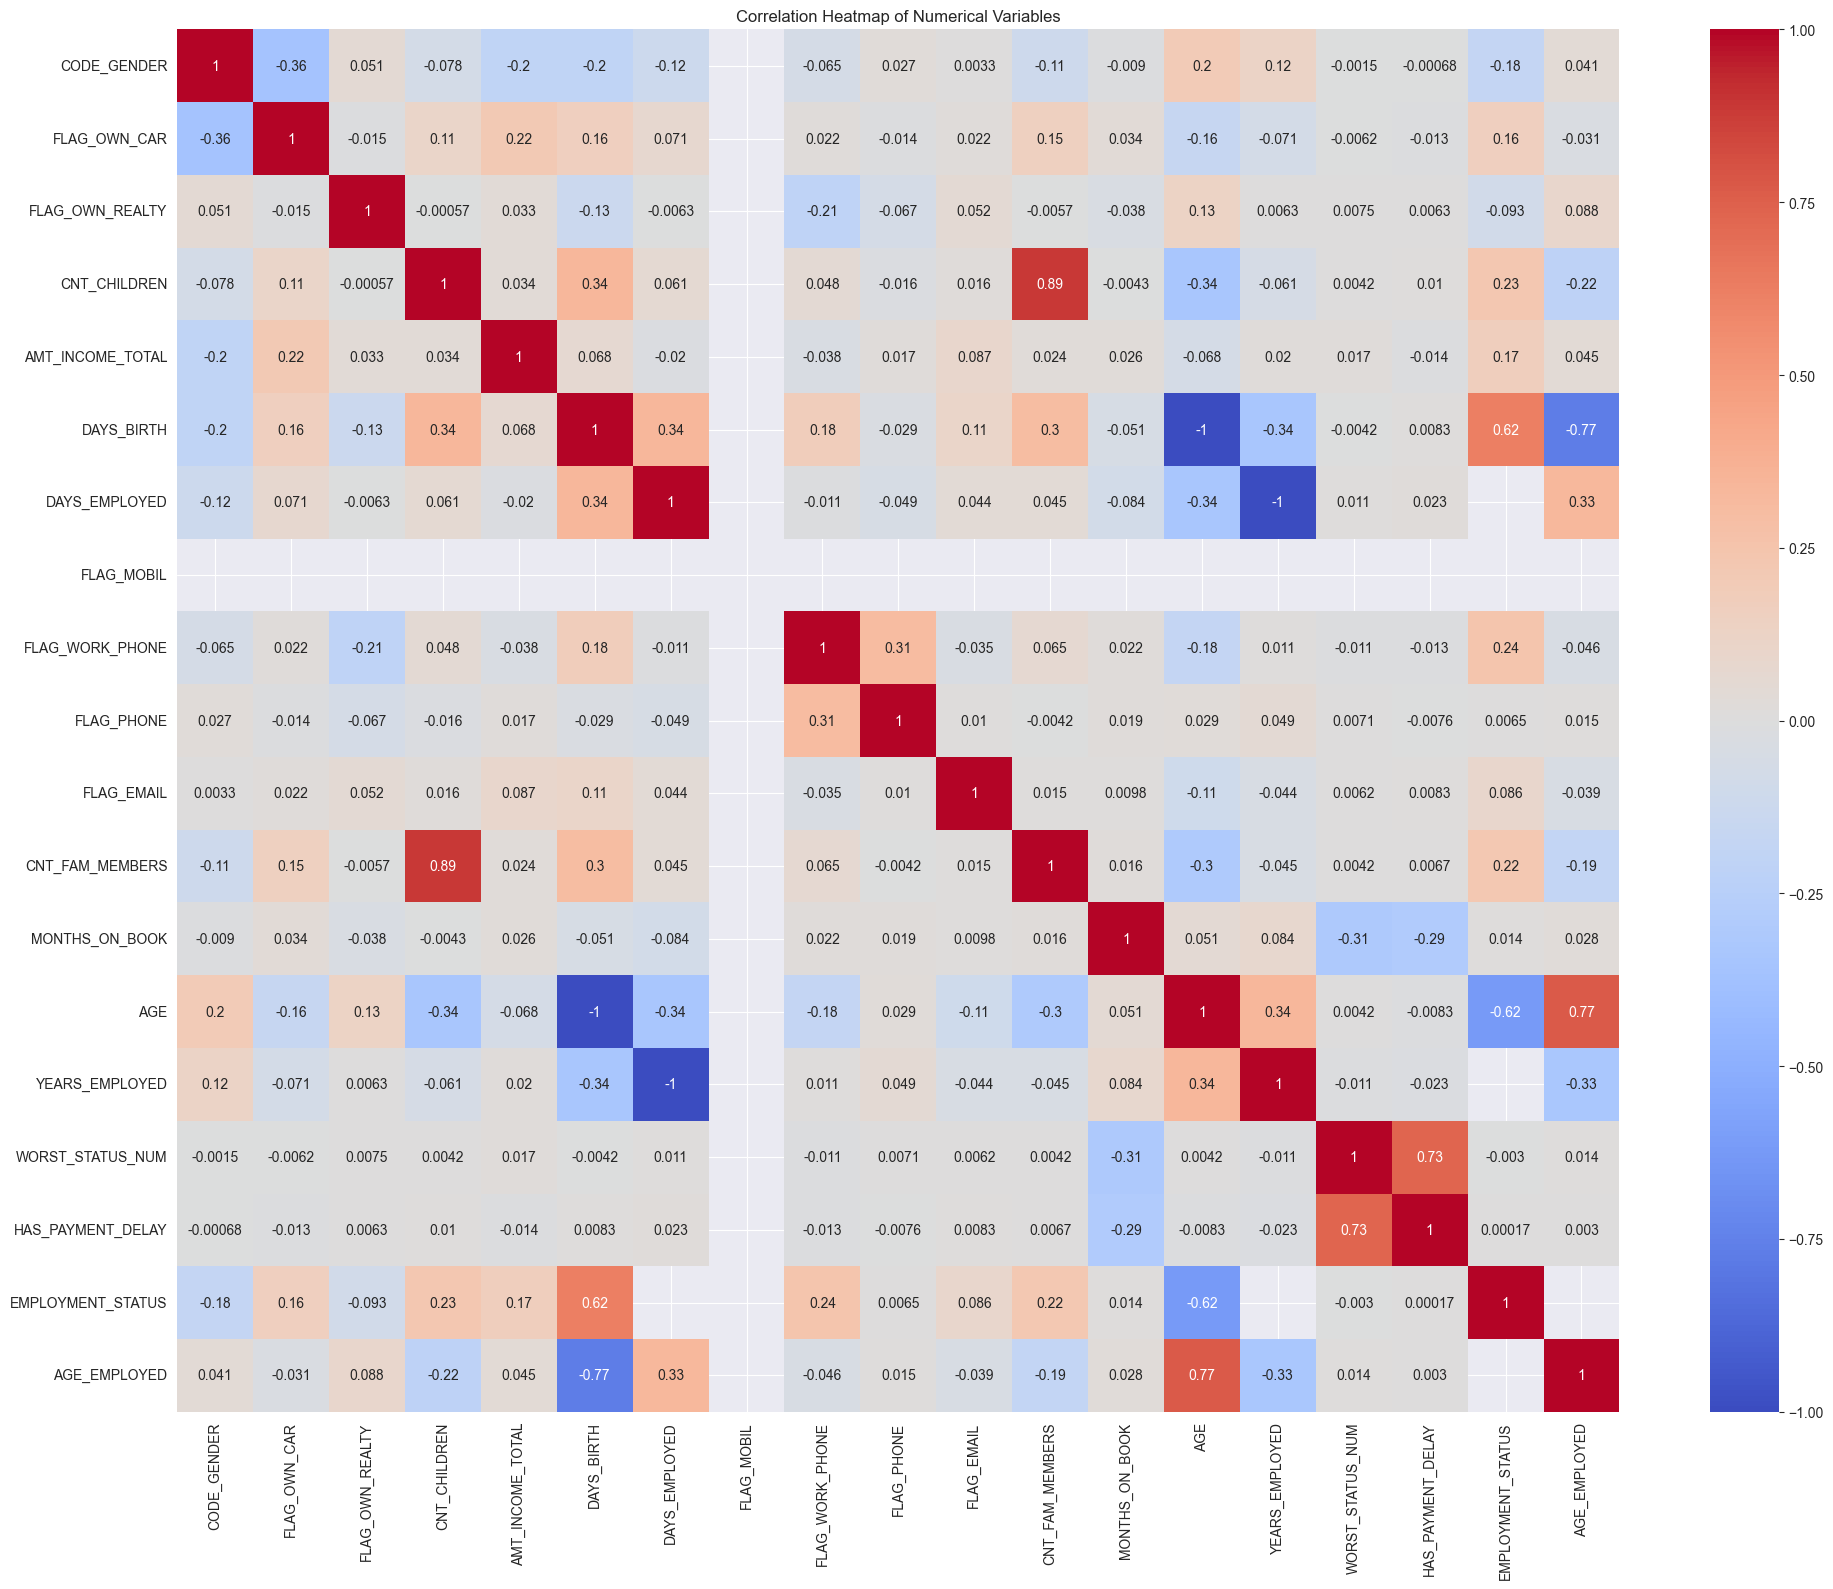

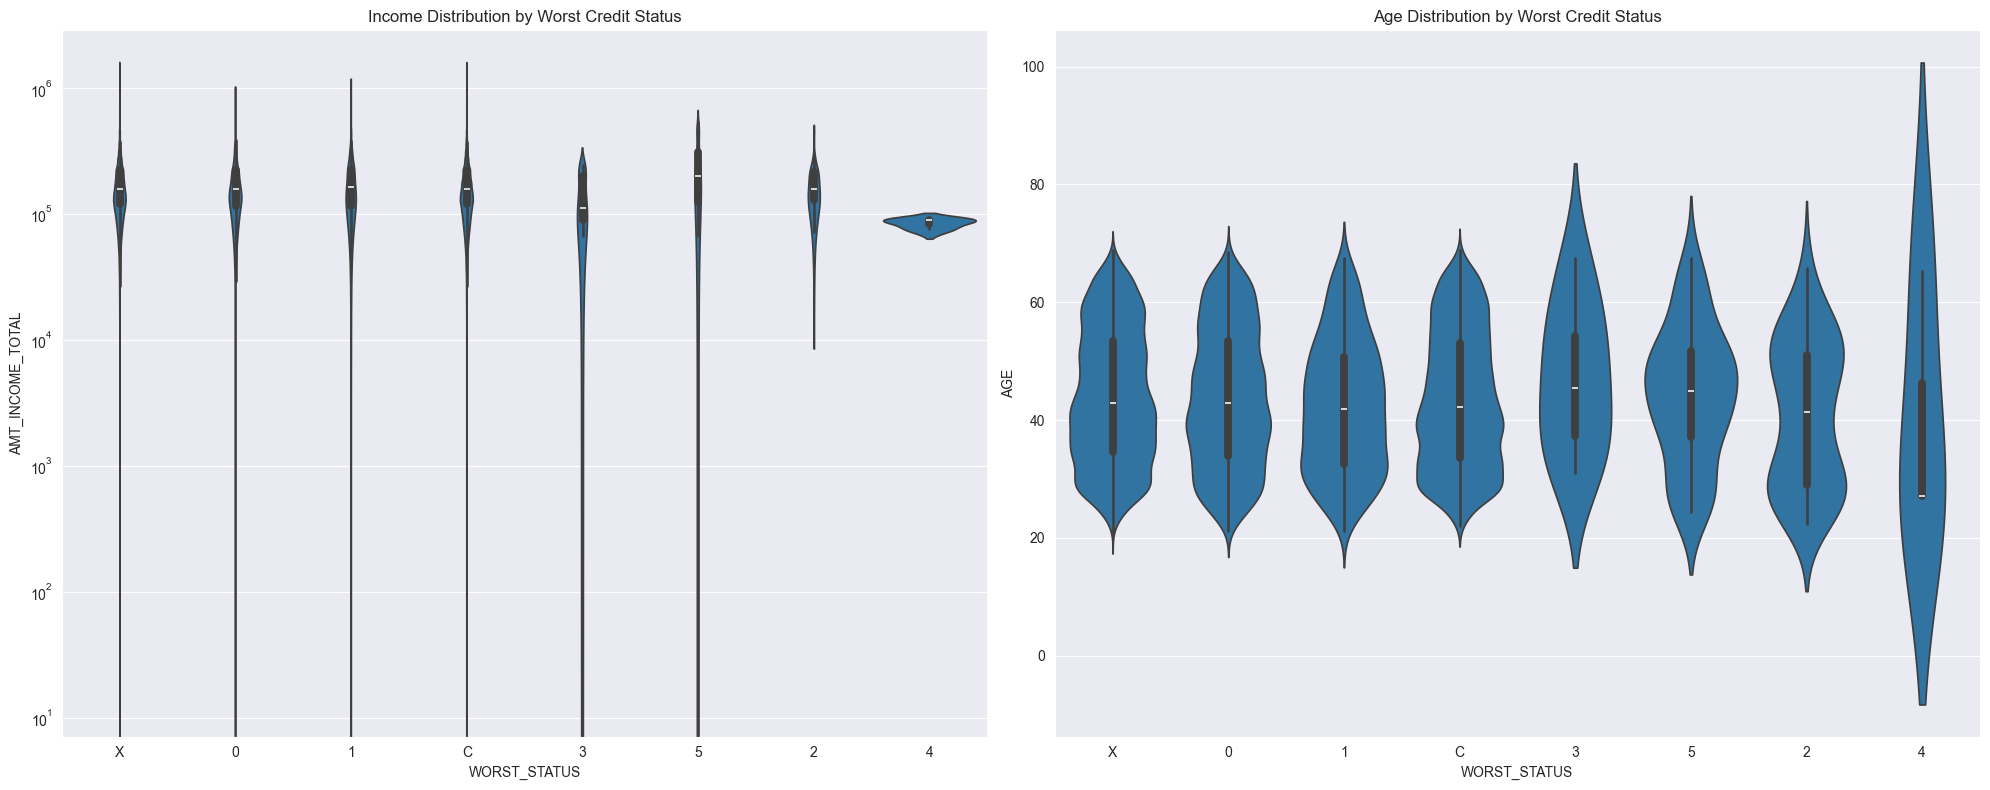

<Figure size 1200x600 with 0 Axes>

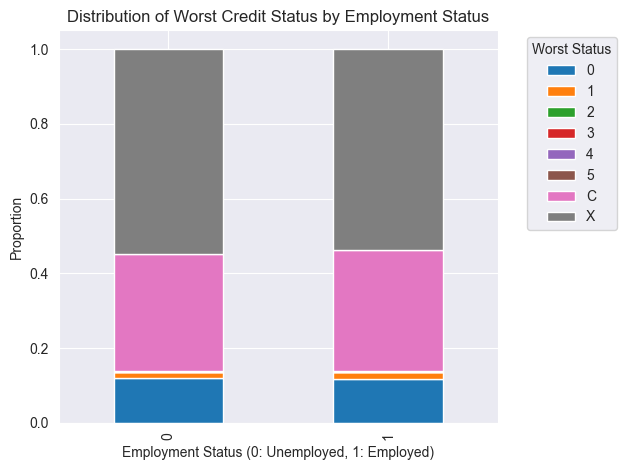

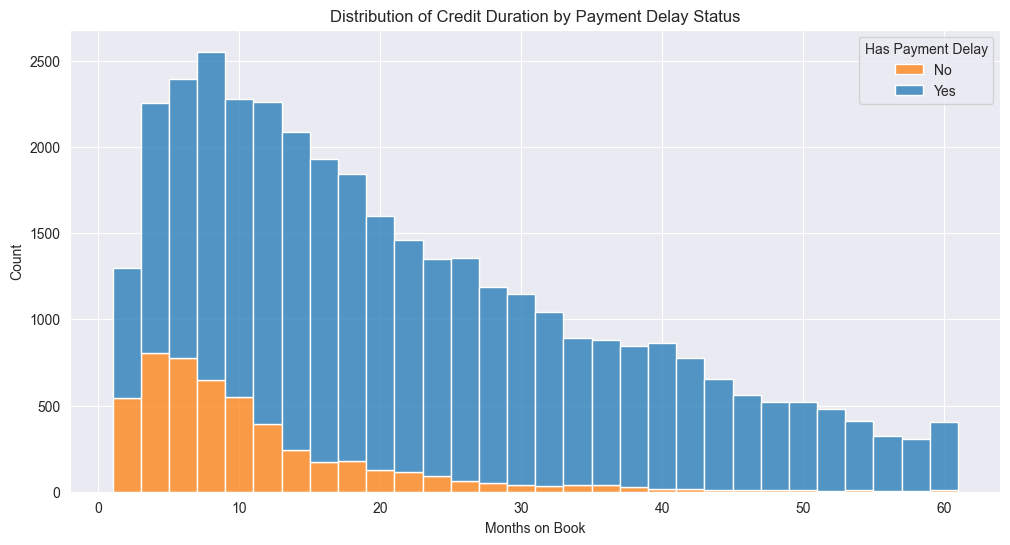

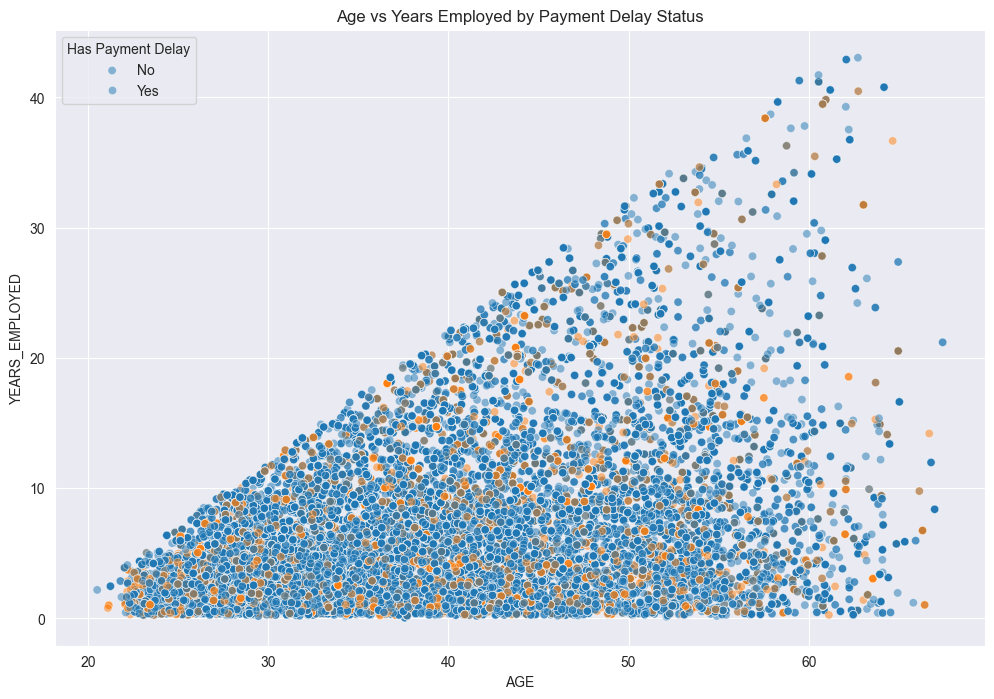

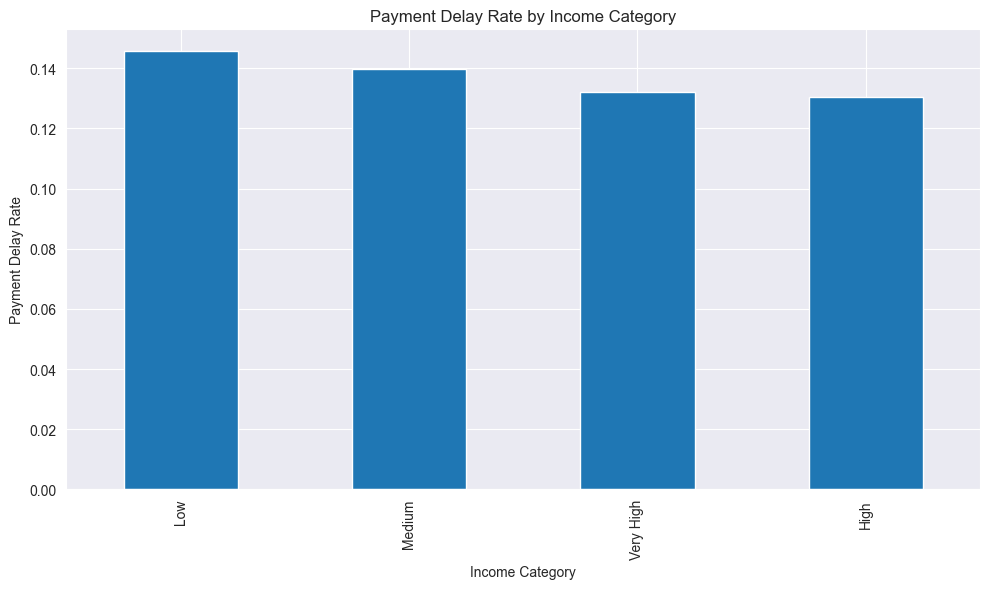

In [10]:
# Replace the placeholder 365243 from DAYS_EMPLOYED field with np.nan
combined_df['DAYS_EMPLOYED'] = combined_df['DAYS_EMPLOYED'].replace(365243, np.nan)

# Update YEARS_EMPLOYED based on the new DAYS_EMPLOYED
combined_df['YEARS_EMPLOYED'] = np.abs(combined_df['DAYS_EMPLOYED']) / 365

# Update EMPLOYMENT_STATUS column
combined_df['EMPLOYMENT_STATUS'] = np.where(combined_df['DAYS_EMPLOYED'].notna(), 1, 0)

# Select numerical columns for analysis
numerical_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL',
'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
'MONTHS_ON_BOOK', 'AGE', 'YEARS_EMPLOYED', 'WORST_STATUS_NUM',
'HAS_PAYMENT_DELAY', 'EMPLOYMENT_STATUS', 'AGE_EMPLOYED']

# Create a correlation matrix
corr_matrix = combined_df[numerical_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numerical Variables')
plt.tight_layout()
plt.show()

# Violin plots for income and age by worst status
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.violinplot(x='WORST_STATUS', y='AMT_INCOME_TOTAL', data=combined_df, ax=ax1)
ax1.set_title('Income Distribution by Worst Credit Status')
ax1.set_yscale('log')

sns.violinplot(x='WORST_STATUS', y='AGE', data=combined_df, ax=ax2)
ax2.set_title('Age Distribution by Worst Credit Status')

plt.tight_layout()
plt.show()

# Stacked bar chart for employment status vs worst status
employment_status_crosstab = pd.crosstab(combined_df['EMPLOYMENT_STATUS'], combined_df['WORST_STATUS'], normalize='index')
plt.figure(figsize=(12, 6))
employment_status_crosstab.plot(kind='bar', stacked=True)
plt.title('Distribution of Worst Credit Status by Employment Status')
plt.xlabel('Employment Status (0: Unemployed, 1: Employed)')
plt.ylabel('Proportion')
plt.legend(title='Worst Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Histogram of credit duration (MONTHS_ON_BOOK) by payment delay status
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='MONTHS_ON_BOOK', hue='HAS_PAYMENT_DELAY', multiple='stack', bins=30)
plt.title('Distribution of Credit Duration by Payment Delay Status')
plt.xlabel('Months on Book')
plt.ylabel('Count')
plt.legend(title='Has Payment Delay', labels=['No', 'Yes'])
plt.show()

# Scatter plot of Age vs Years Employed, colored by payment delay status
plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined_df, x='AGE', y='YEARS_EMPLOYED', hue='HAS_PAYMENT_DELAY', alpha=0.5)
plt.title('Age vs Years Employed by Payment Delay Status')
plt.legend(title='Has Payment Delay', labels=['No', 'Yes'])
plt.show()

# Bar plot of payment delay rate by income category
income_delay_rate = combined_df.groupby('INCOME_CATEGORY')['HAS_PAYMENT_DELAY'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
income_delay_rate.plot(kind='bar')
plt.title('Payment Delay Rate by Income Category')
plt.ylabel('Payment Delay Rate')
plt.xlabel('Income Category')
plt.tight_layout()
plt.show()

In [11]:
# Prepare the data
X = combined_df.drop(['HAS_PAYMENT_DELAY', 'WORST_STATUS', 'WORST_STATUS_NUM'], axis=1)
y = combined_df['HAS_PAYMENT_DELAY']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to display class distribution
def display_class_distribution(y, title):
    distribution = y.value_counts(normalize=True).reset_index()
    distribution.columns = ['Class', 'Proportion']
    styled_dist = distribution.style.format({'Proportion': '{:.2%}'})
    display(HTML(f"<h3>{title}</h3>"))
    display(styled_dist)

# Display original distribution
display_class_distribution(y_train, "Original Class Distribution")

,Class,Proportion
0,False,86.11%
1,True,13.89%


In [12]:
# Approach: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Prepare the data (assuming we're using the imputed dataset)
X = X_train_imputed.copy()
y = y_train.copy()

# Feature Engineering
X['DEBT_TO_INCOME'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']

# Check if AGE_GROUP columns already exist
age_group_columns = [col for col in X.columns if col.startswith('AGE_GROUP_')]
if not age_group_columns:
    # If AGE_GROUP columns don't exist, create them
    X['AGE_GROUP'] = pd.cut(X['AGE'], bins=[0, 25, 35, 45, 55, 65, 100], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    X = pd.get_dummies(X, columns=['AGE_GROUP'])

# Check if INCOME_BRACKET columns already exist
income_bracket_columns = [col for col in X.columns if col.startswith('INCOME_BRACKET_')]
if not income_bracket_columns:
    # If INCOME_BRACKET columns don't exist, create them
    X['INCOME_BRACKET'] = pd.qcut(X['AMT_INCOME_TOTAL'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    X = pd.get_dummies(X, columns=['INCOME_BRACKET'])

# Check for any remaining duplicate columns
duplicate_columns = X.columns[X.columns.duplicated()].tolist()
if duplicate_columns:
    print(f"Duplicate columns found: {duplicate_columns}")
    X = X.loc[:, ~X.columns.duplicated()]

# Feature Selection using RFE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=20, step=1)
rfe_selector = rfe_selector.fit(X_scaled, y)

selected_features = X.columns[rfe_selector.support_]
X_selected = X[selected_features]

# Apply SMOTE on selected features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_selected, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Function to get metrics
def get_metrics(y_true, y_pred, y_pred_proba):
    report = classification_report(y_true, y_pred, output_dict=True)
    auc = roc_auc_score(y_true, y_pred_proba)
    return {
        'Accuracy': report['accuracy'],
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score'],
        'ROC AUC': auc
    }

# Create a StandardScaler
scaler = StandardScaler()

# Train and evaluate multiple models
models = {
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=1000)),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbors': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME', random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42, tree_method='auto'),
    'LightGBM': LGBMClassifier(random_state=42, device_type='gpu')
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = get_metrics(y_test, y_pred, y_pred_proba)
    results.append({'Model': name, **metrics})

# Create a DataFrame with the results
results_df = pd.DataFrame(results)

# Style the DataFrame
styled_results = results_df.style.format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-score': '{:.4f}',
    'ROC AUC': '{:.4f}'
}).background_gradient(cmap='YlGnBu', subset=['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC'])

# Display the results
display(HTML("<h3>Model Evaluation Results</h3>"))
display(styled_results)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20058, number of negative: 20122
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4406
[LightGBM] [Info] Number of data points in the train set: 40180, number of used features: 19
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.46 MB) transferred to GPU in 0.001139 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499204 -> initscore=-0.003186
[LightGBM] [Info] Start training from score -0.003186


,Model,Accuracy,Precision,Recall,F1-score,ROC AUC
0,Logistic Regression,0.7150,0.7239,0.7150,0.7118,0.7726
1,Random Forest,0.9180,0.9183,0.9180,0.9180,0.9718
2,Gradient Boosting,0.8378,0.8379,0.8378,0.8378,0.9243
3,Support Vector Machine,0.8082,0.8082,0.8082,0.8082,0.8968
4,Naive Bayes,0.6882,0.7204,0.6882,0.6758,0.7595
5,K-Nearest Neighbors,0.8512,0.8524,0.8512,0.8510,0.9250
6,Decision Tree,0.8923,0.8923,0.8923,0.8923,0.8926
7,AdaBoost,0.7560,0.7663,0.7560,0.7534,0.8713
8,Extra Trees,0.9198,0.9199,0.9198,0.9198,0.9638
9,XGBoost,0.9014,0.9060,0.9014,0.9011,0.9648


In [13]:
def add_noise(X, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    noisy_X = X.copy()
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64']:
            noisy_X[col] += noise[:, X.columns.get_loc(col)]
    return noisy_X

# Create noisy test data
X_test_noisy = add_noise(X_test)
noise_results = []

# Test all models with noisy data
for name, model in models.items():
    y_pred_noisy = model.predict(X_test_noisy)
    noisy_accuracy = (y_pred_noisy == y_test).mean()
    noisy_precision = precision_score(y_test, y_pred_noisy, average='weighted')
    noisy_recall = recall_score(y_test, y_pred_noisy, average='weighted')
    noisy_f1 = f1_score(y_test, y_pred_noisy, average='weighted')
    noisy_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_noisy)[:, 1])

    noise_results.append({
        'Model': name,
        'Noisy Accuracy': noisy_accuracy,
        'Noisy Precision': noisy_precision,
        'Noisy Recall': noisy_recall,
        'Noisy F1-score': noisy_f1,
        'Noisy ROC AUC': noisy_roc_auc
    })

# Create a DataFrame with the results
noise_results_df = pd.DataFrame(noise_results)

# Sort the results by Noisy F1-score (or any other metric you prefer)
noise_results_df = noise_results_df.sort_values('Noisy F1-score', ascending=False)

# Style the DataFrame
styled_noise_results = noise_results_df.style.format({
    'Noisy Accuracy': '{:.4f}',
    'Noisy Precision': '{:.4f}',
    'Noisy Recall': '{:.4f}',
    'Noisy F1-score': '{:.4f}',
    'Noisy ROC AUC': '{:.4f}'
    }).background_gradient(cmap='YlGnBu', subset=['Noisy Accuracy', 'Noisy Precision', 'Noisy Recall', 'Noisy F1-score', 'Noisy ROC AUC'])

# Display the results
display(HTML("<h3>Model Performance with 5% Noise</h3>"))
display(styled_noise_results)

,Model,Noisy Accuracy,Noisy Precision,Noisy Recall,Noisy F1-score,Noisy ROC AUC
5,K-Nearest Neighbors,0.8479,0.8494,0.8479,0.8477,0.9233
0,Logistic Regression,0.7073,0.7145,0.7073,0.7046,0.7619
4,Naive Bayes,0.6881,0.7204,0.6881,0.6756,0.7595
3,Support Vector Machine,0.6358,0.7068,0.6358,0.6029,0.7141
8,Extra Trees,0.6041,0.7652,0.6041,0.5315,0.9267
6,Decision Tree,0.5916,0.7445,0.5916,0.5139,0.5890
7,AdaBoost,0.5695,0.7115,0.5695,0.4801,0.7441
1,Random Forest,0.5369,0.7450,0.5369,0.4092,0.8331
2,Gradient Boosting,0.5196,0.7118,0.5196,0.3751,0.6927
10,LightGBM,0.5195,0.7483,0.5195,0.3725,0.7219


In [14]:
# Function to create randomized data
def create_random_data(X, y):
    random_X = X.copy()
    for col in random_X.columns:
        random_X[col] = np.random.permutation(random_X[col].values)
    random_y = np.random.permutation(y)
    return random_X, random_y

# Create randomized test data
X_test_random, y_test_random = create_random_data(X_test, y_test)
sanity_results = []

# Test all models with randomized data to check data leak
for name, model in models.items():
    y_pred_random = model.predict(X_test_random)
    random_accuracy = accuracy_score(y_test_random, y_pred_random)
    random_precision = precision_score(y_test_random, y_pred_random, average='weighted')
    random_recall = recall_score(y_test_random, y_pred_random, average='weighted')
    random_f1 = f1_score(y_test_random, y_pred_random, average='weighted')
    random_roc_auc = roc_auc_score(y_test_random, model.predict_proba(X_test_random)[:, 1])

    sanity_results.append({
        'Model': name,
        'Random Accuracy': random_accuracy,
        'Random Precision': random_precision,
        'Random Recall': random_recall,
        'Random F1-score': random_f1,
        'Random ROC AUC': random_roc_auc
    })

# Create a DataFrame with the results
sanity_results_df = pd.DataFrame(sanity_results)

# Sort the results by Random F1-score (or any other metric you prefer)
sanity_results_df = sanity_results_df.sort_values('Random F1-score', ascending=False)

# Style the DataFrame
styled_sanity_results = sanity_results_df.style.format({
    'Random Accuracy': '{:.4f}',
    'Random Precision': '{:.4f}',
    'Random Recall': '{:.4f}',
    'Random F1-score': '{:.4f}',
    'Random ROC AUC': '{:.4f}'
}).background_gradient(cmap='YlGnBu', subset=['Random Accuracy', 'Random Precision', 'Random Recall', 'Random F1-score', 'Random ROC AUC'])

# Display the results
display(HTML("<h3>Model Performance on Randomized Data (Sanity Test)</h3>"))
display(styled_sanity_results)

,Model,Random Accuracy,Random Precision,Random Recall,Random F1-score,Random ROC AUC
2,Gradient Boosting,0.5036,0.5034,0.5036,0.5029,0.5000
10,LightGBM,0.5044,0.5041,0.5044,0.5024,0.5023
8,Extra Trees,0.5018,0.5016,0.5018,0.5013,0.5027
5,K-Nearest Neighbors,0.5004,0.5008,0.5004,0.4987,0.5013
6,Decision Tree,0.4983,0.4981,0.4983,0.4978,0.4981
1,Random Forest,0.4981,0.4984,0.4981,0.4973,0.5007
9,XGBoost,0.5003,0.4998,0.5003,0.4971,0.4998
7,AdaBoost,0.5039,0.5033,0.5039,0.4966,0.5013
0,Logistic Regression,0.4968,0.4961,0.4968,0.4922,0.4945
3,Support Vector Machine,0.4915,0.4917,0.4915,0.4912,0.4937


In [15]:
def combine_results(results_df, noise_results_df, original_weight=0.4, noise_weight=0.6):
    # Ensure both DataFrames have the same models in the same order
    combined_df = results_df.merge(noise_results_df, on='Model', suffixes=('', '_noisy'))
    
    # Calculate weighted scores
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC']
    for metric in metrics:
        combined_df[f'Weighted_{metric}'] = (
            original_weight * combined_df[metric] + 
            noise_weight * combined_df[f'Noisy {metric}']
        )
    
    # Calculate overall score (average of all weighted metrics)
    combined_df['Overall_Score'] = combined_df[[f'Weighted_{metric}' for metric in metrics]].mean(axis=1)
    
    return combined_df

# Combine results
combined_results = combine_results(results_df, noise_results_df)

# Sort by Overall Score
combined_results = combined_results.sort_values('Overall_Score', ascending=False)

# Select the best model based on the Overall Score
best_model_name = combined_results.iloc[0]['Model']
best_model = models[best_model_name]

# Display combined results
display(HTML("<h3>Combined Model Evaluation Results</h3>"))
styled_combined_results = combined_results.style.format({
    col: '{:.4f}' for col in combined_results.columns if col != 'Model'
}).background_gradient(cmap='YlGnBu', subset=[col for col in combined_results.columns if col != 'Model'])
display(styled_combined_results)

print(f"\nThe best performing model based on combined scores is: {best_model_name}")

,Model,Accuracy,Precision,Recall,F1-score,ROC AUC,Noisy Accuracy,Noisy Precision,Noisy Recall,Noisy F1-score,Noisy ROC AUC,Weighted_Accuracy,Weighted_Precision,Weighted_Recall,Weighted_F1-score,Weighted_ROC AUC,Overall_Score
5,K-Nearest Neighbors,0.8512,0.8524,0.8512,0.8510,0.9250,0.8479,0.8494,0.8479,0.8477,0.9233,0.8492,0.8506,0.8492,0.8490,0.9240,0.8644
8,Extra Trees,0.9198,0.9199,0.9198,0.9198,0.9638,0.6041,0.7652,0.6041,0.5315,0.9267,0.7304,0.8271,0.7304,0.6868,0.9415,0.7832
1,Random Forest,0.9180,0.9183,0.9180,0.9180,0.9718,0.5369,0.7450,0.5369,0.4092,0.8331,0.6893,0.8144,0.6893,0.6127,0.8886,0.7389
3,Support Vector Machine,0.8082,0.8082,0.8082,0.8082,0.8968,0.6358,0.7068,0.6358,0.6029,0.7141,0.7047,0.7474,0.7047,0.6850,0.7872,0.7258
0,Logistic Regression,0.7150,0.7239,0.7150,0.7118,0.7726,0.7073,0.7145,0.7073,0.7046,0.7619,0.7104,0.7183,0.7104,0.7075,0.7661,0.7225
6,Decision Tree,0.8923,0.8923,0.8923,0.8923,0.8926,0.5916,0.7445,0.5916,0.5139,0.5890,0.7119,0.8036,0.7119,0.6653,0.7104,0.7206
10,LightGBM,0.8975,0.9029,0.8975,0.8972,0.9607,0.5195,0.7483,0.5195,0.3725,0.7219,0.6707,0.8102,0.6707,0.5824,0.8174,0.7103
4,Naive Bayes,0.6882,0.7204,0.6882,0.6758,0.7595,0.6881,0.7204,0.6881,0.6756,0.7595,0.6882,0.7204,0.6882,0.6757,0.7595,0.7064
9,XGBoost,0.9014,0.9060,0.9014,0.9011,0.9648,0.5093,0.7293,0.5093,0.3508,0.7139,0.6661,0.8000,0.6661,0.5709,0.8142,0.7035
7,AdaBoost,0.7560,0.7663,0.7560,0.7534,0.8713,0.5695,0.7115,0.5695,0.4801,0.7441,0.6441,0.7334,0.6441,0.5895,0.7950,0.6812



The best performing model based on combined scores is: K-Nearest Neighbors


,feature,importance
5,MONTHS_ON_BOOK,0.1592
0,ID,0.1009
10,NAME_EDUCATION_TYPE_Higher education,0.0765
1,AMT_INCOME_TOTAL,0.0729
11,NAME_FAMILY_STATUS_Married,0.0700
4,CNT_FAM_MEMBERS,0.0651
2,DAYS_BIRTH,0.0646
6,YEARS_EMPLOYED,0.0621
18,AGE_GROUP_26-35,0.0594
8,AGE_EMPLOYED,0.0582


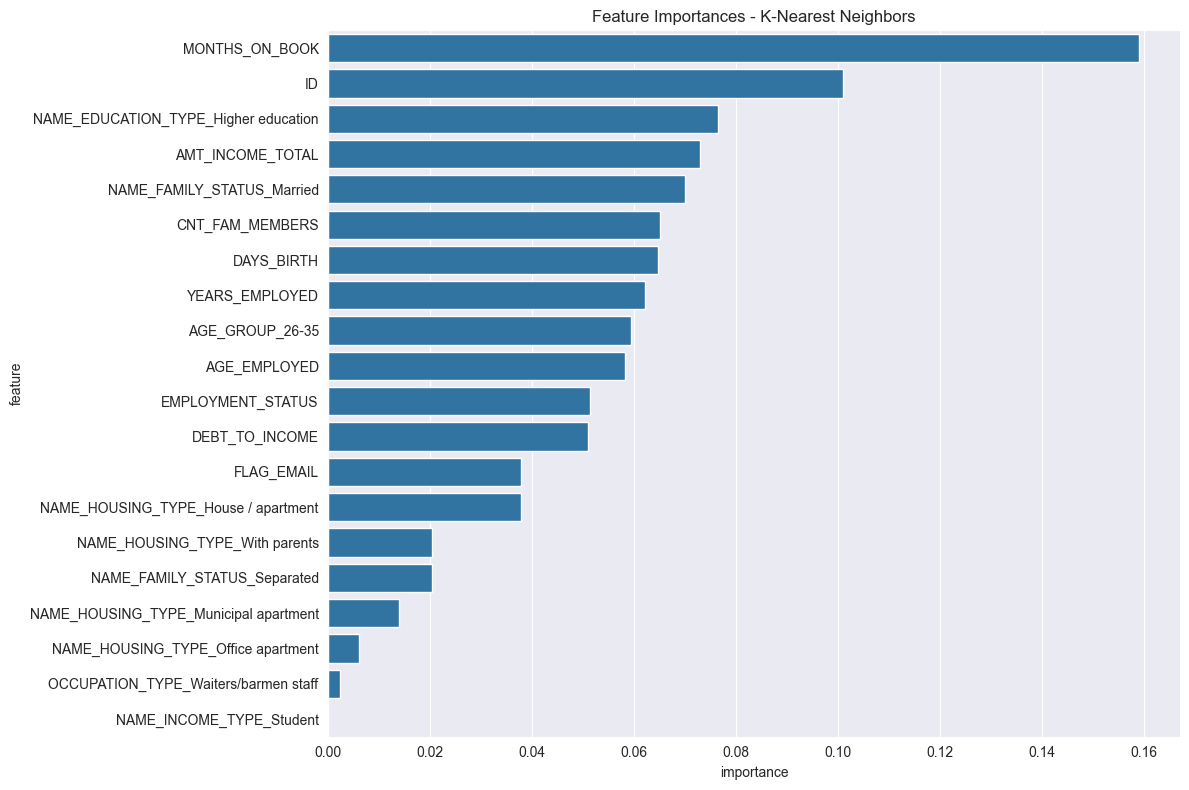

,count,mean,std,min,25%,50%,75%,max
ID,1495.00,5077878.86,41468.91,5008847.00,5042198.69,5069342.00,5113823.00,5150451.00
AMT_INCOME_TOTAL,1495.00,183488.42,94685.85,36000.00,113181.36,157500.00,225000.00,920883.30
DAYS_BIRTH,1495.00,-16255.81,4170.95,-24758.00,-19683.50,-15934.00,-13085.58,-8054.00
FLAG_EMAIL,1495.00,0.09,0.28,0.00,0.00,0.00,0.00,1.00
CNT_FAM_MEMBERS,1495.00,2.21,0.92,1.00,2.00,2.00,3.00,6.00
MONTHS_ON_BOOK,1495.00,13.03,9.81,1.00,6.00,10.28,17.00,57.00
YEARS_EMPLOYED,1495.00,7.07,5.87,0.19,3.02,6.63,8.42,39.49
EMPLOYMENT_STATUS,1495.00,0.82,0.38,0.00,1.00,1.00,1.00,1.00
AGE_EMPLOYED,1495.00,33.96,8.30,18.02,27.90,33.30,38.67,59.73
NAME_INCOME_TYPE_Student,1495.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


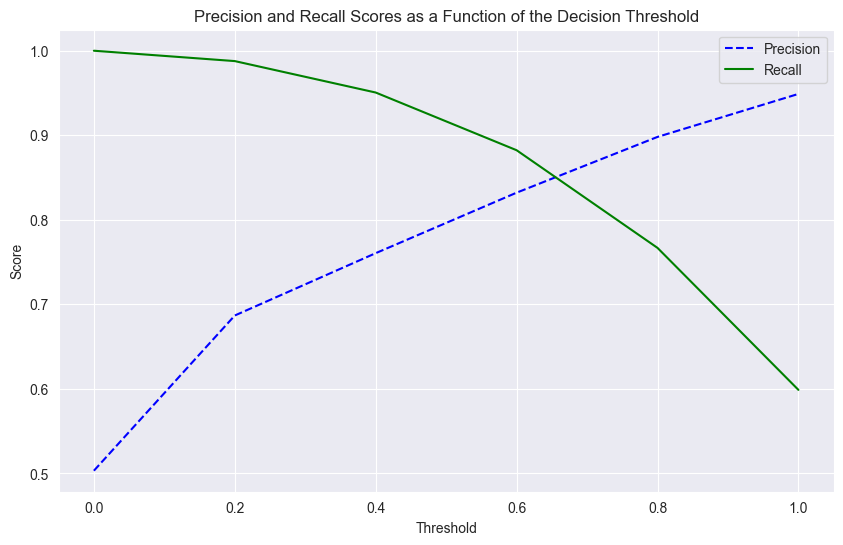

,Metric,Value
0,Best threshold for F1 score,0.6000


,precision,recall,f1-score,support
False,0.8730,0.8197,0.8455,4991.0000
True,0.8321,0.8823,0.8565,5055.0000
accuracy,0.8512,0.8512,0.8512,0.8512
macro avg,0.8526,0.8510,0.8510,10046.0000
weighted avg,0.8524,0.8512,0.8510,10046.0000


,Metric,Value
0,ROC AUC Score,0.9250


,Metric,Value
0,Train Accuracy,0.9073
1,Test Accuracy,0.8512


In [16]:
# Feature importance analysis for the best performing model
def get_feature_importance(model, X, y):
    if hasattr(model, 'feature_importances_'):
        # For models like Random Forest that have feature_importances_ attribute
        return pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
    elif isinstance(model, Pipeline):
        # For pipeline objects, check if the last step has feature_importances_
        last_step = model.steps[-1][1]
        if hasattr(last_step, 'feature_importances_'):
            return pd.DataFrame({
                'feature': X.columns,
                'importance': last_step.feature_importances_
            }).sort_values('importance', ascending=False)
    
    # For other models, use permutation importance
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    return pd.DataFrame({
        'feature': X.columns,
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False)

feature_importance = get_feature_importance(best_model, X_test, y_test)

styled_importance = feature_importance.style.format({'importance': '{:.4f}'}).background_gradient(cmap='YlOrRd', subset=['importance'])
display(HTML(f"<h3>Feature Importances - {best_model_name}</h3>"))
display(styled_importance)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title(f'Feature Importances - {best_model_name}')
plt.tight_layout()
plt.show()

# Analyze misclassifications
y_pred = best_model.predict(X_test)
misclassified = X_test.loc[y_pred != y_test].copy()
misclassified.loc[:, 'true_label'] = y_test[y_pred != y_test].values
misclassified.loc[:, 'predicted_label'] = y_pred[y_pred != y_test]

misclassified_stats = misclassified.describe().T
styled_misclassified = misclassified_stats.style.format('{:.2f}').background_gradient(cmap='coolwarm')
display(HTML("<h3>Misclassified Samples Statistics</h3>"))
display(styled_misclassified)

# # Analyze feature distributions for correctly classified vs misclassified samples
# for feature in X_selected.columns:
#     plt.figure(figsize=(10, 6))
#     sns.kdeplot(data=X_test[y_pred == y_test], x=feature, label='Correct', fill=True)
#     sns.kdeplot(data=X_test[y_pred != y_test], x=feature, label='Misclassified', fill=True)
#     plt.title(f'Distribution of {feature} for Correct vs Misclassified Samples')
#     plt.legend()
#     plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, best_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Scores as a Function of the Decision Threshold')
plt.legend()
plt.show()

# Find the threshold that gives the best F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores[:-1])]

threshold_df = pd.DataFrame({'Metric': ['Best threshold for F1 score'], 'Value': [best_threshold]})
styled_threshold = threshold_df.style.format({'Value': '{:.4f}'})
display(HTML("<h3>Best Threshold for F1 Score</h3>"))
display(styled_threshold)

# Evaluate model performance with the best threshold
y_pred_best_threshold = (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
performance_report = classification_report(y_test, y_pred_best_threshold, output_dict=True)
performance_df = pd.DataFrame(performance_report).transpose()
styled_performance = performance_df.style.format('{:.4f}').background_gradient(cmap='YlGnBu')
display(HTML("<h3>Model Performance with Best Threshold</h3>"))
display(styled_performance)

roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
roc_df = pd.DataFrame({'Metric': ['ROC AUC Score'], 'Value': [roc_auc]})
styled_roc = roc_df.style.format({'Value': '{:.4f}'})
display(styled_roc)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_accuracy = (y_train_pred == y_train).mean()
test_accuracy = (y_test_pred == y_test).mean()

accuracy_df = pd.DataFrame({
    'Metric': ['Train Accuracy', 'Test Accuracy'],
    'Value': [train_accuracy, test_accuracy]
})
styled_accuracy = accuracy_df.style.format({'Value': '{:.4f}'}).background_gradient(cmap='YlGnBu', subset=['Value'])
display(HTML("<h3>Train and Test Accuracy</h3>"))
display(styled_accuracy)


,precision,recall,f1-score,support
False,0.8730,0.8197,0.8455,4991.0000
True,0.8321,0.8823,0.8565,5055.0000
accuracy,0.8512,0.8512,0.8512,0.8512
macro avg,0.8526,0.8510,0.8510,10046.0000
weighted avg,0.8524,0.8512,0.8510,10046.0000


,Metric,Value
0,ROC AUC Score,0.9250


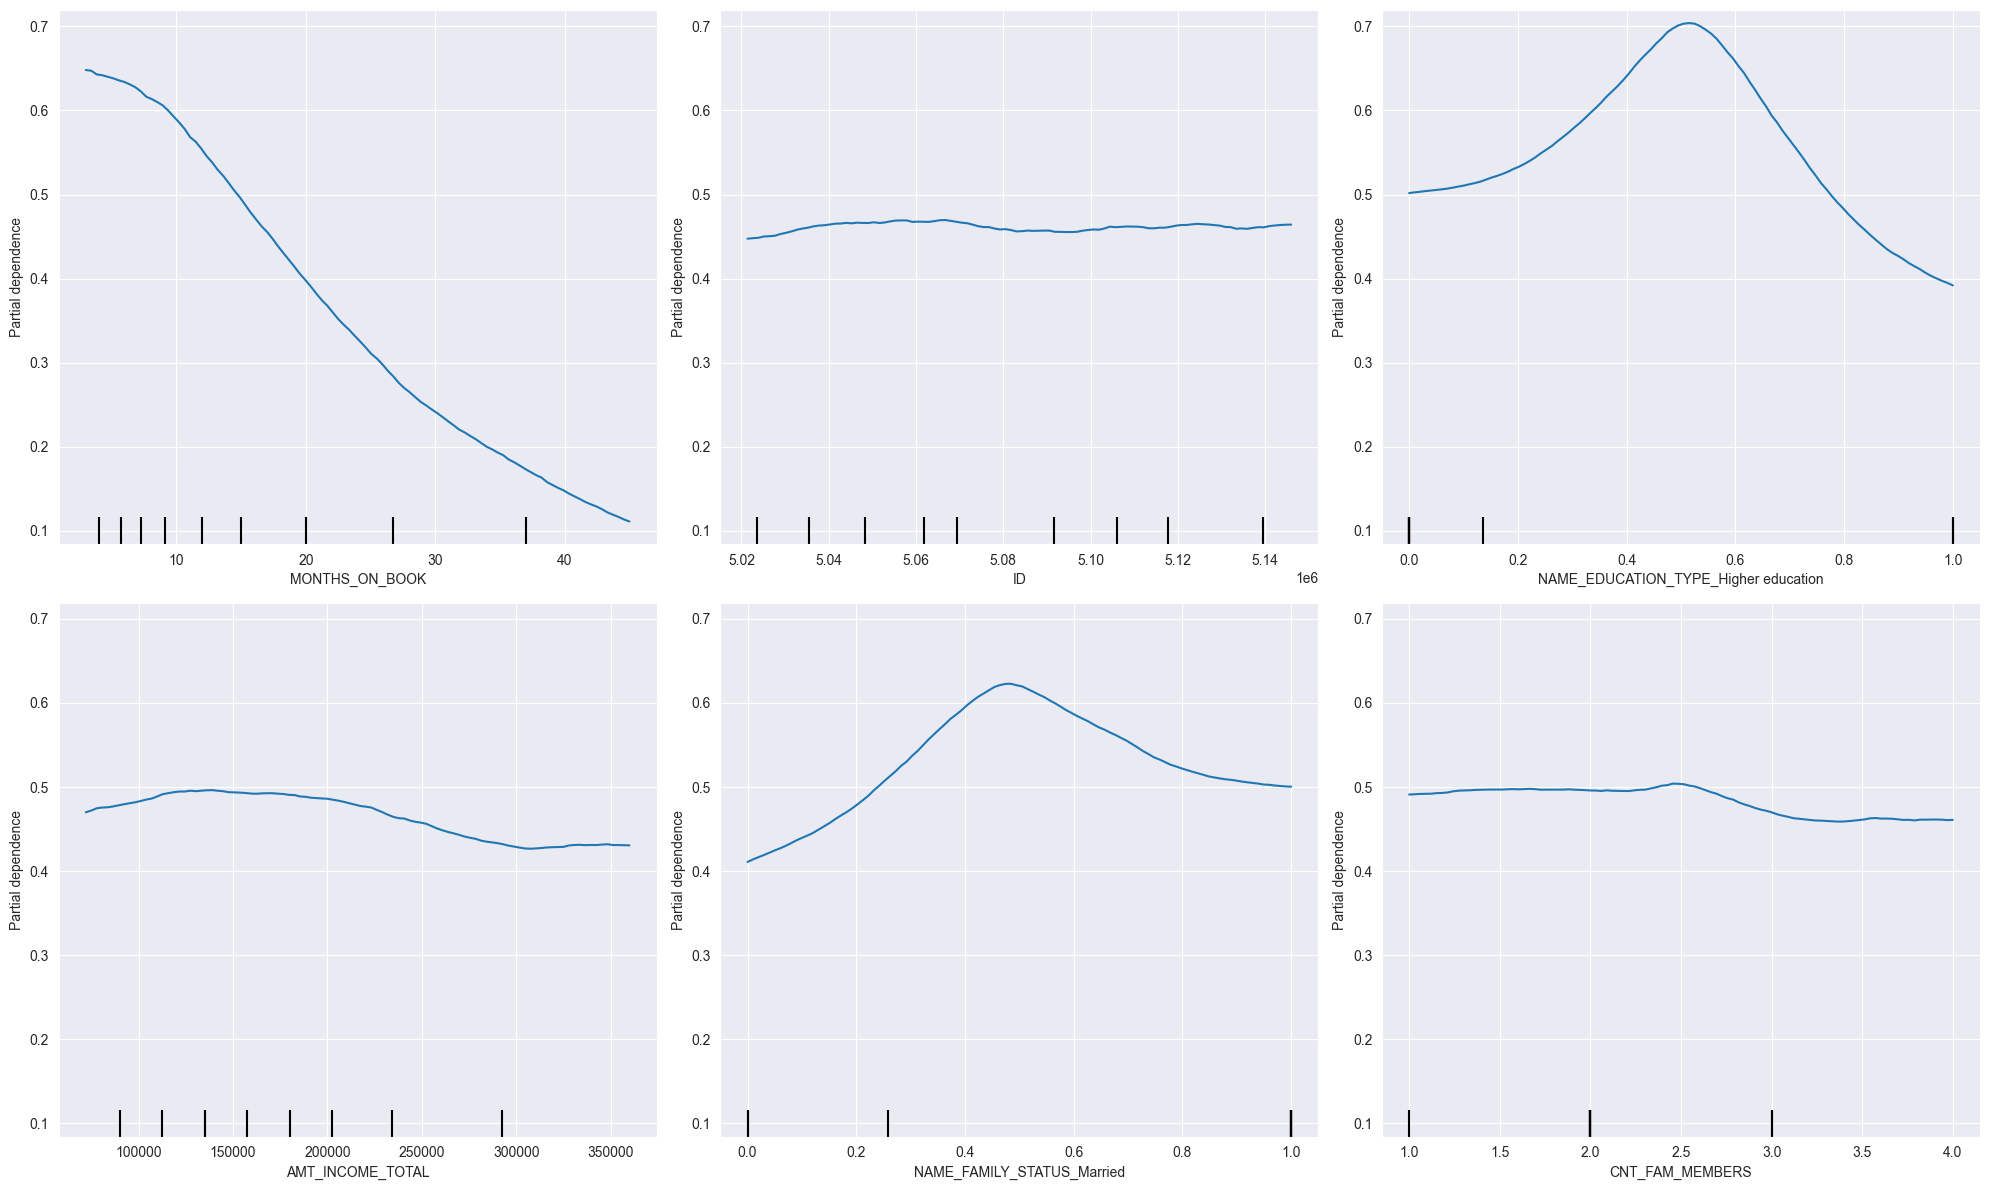

,Fold,ROC AUC
0,1,0.8841
1,2,0.9383
2,3,0.9410
3,4,0.9417
4,5,0.9413
5,Mean,0.9293
6,Std Dev,0.0226


,Metric,Value
0,Mean ROC AUC,0.9293
1,Standard Deviation,0.0452


In [17]:
# Evaluate the model with the new threshold
y_pred_best_threshold = (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)

# Create a DataFrame for classification report
report = classification_report(y_test, y_pred_best_threshold, output_dict=True)
report_df = pd.DataFrame(report).transpose()
styled_report = report_df.style.format('{:.4f}').background_gradient(cmap='YlGnBu')

display(HTML("<h3>Model Performance with Best Threshold</h3>"))
display(styled_report)

# ROC AUC Score
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
roc_df = pd.DataFrame({'Metric': ['ROC AUC Score'], 'Value': [roc_auc]})
styled_roc = roc_df.style.format({'Value': '{:.4f}'}).background_gradient(cmap='YlGnBu')
display(HTML("<h3>ROC AUC Score</h3>"))
display(styled_roc)

# Partial Dependence Plots
features = feature_importance['feature'].head(6).tolist()  # Top 6 important features
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
PartialDependenceDisplay.from_estimator(best_model, X_test, features, ax=ax.ravel())
plt.tight_layout()
display(HTML("<h3>Partial Dependence Plots</h3>"))
plt.show()

# Cross-validation to ensure model stability
cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='roc_auc')

cv_df = pd.DataFrame({
    'Fold': range(1, 6),
    'ROC AUC': cv_scores
})

# Add Mean and Std Dev rows
cv_df = pd.concat([
    cv_df,
    pd.DataFrame({
        'Fold': ['Mean', 'Std Dev'],
        'ROC AUC': [cv_scores.mean(), cv_scores.std()]
    })
], ignore_index=True)

styled_cv = cv_df.style.format({'ROC AUC': '{:.4f}'}).background_gradient(cmap='YlGnBu', subset=['ROC AUC'])
display(HTML("<h3>Cross-validation ROC AUC Scores</h3>"))
display(styled_cv)

# Display mean and standard deviation
mean_std_df = pd.DataFrame({
    'Metric': ['Mean ROC AUC', 'Standard Deviation'],
    'Value': [cv_scores.mean(), cv_scores.std() * 2]
})
styled_mean_std = mean_std_df.style.format({'Value': '{:.4f}'}).background_gradient(cmap='YlGnBu', subset=['Value'])
display(HTML("<h3>Cross-validation Summary</h3>"))
display(styled_mean_std)
